<a href="https://colab.research.google.com/github/Mr-Smithy-x/ML-Car-Damage-Classification/blob/main/binary_car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Car Damaged with Binary Classification

Binary classification is basically choosing between 0 and 1.
the cut off point is 0.5. if the prediction is `0.83` then that indicates that the car is not damaged. if the prediction is 0.41 then that indicates that the car is damaged.

## Dataset Preparation


In [1]:
!pip install tflite-support

!rm -rf car_damages
!wget https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages/training/00-damage.zip
!wget https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages/training/01-whole.zip
!mkdir car_damages
!mkdir car_damages/training
!mkdir car_damages/validation

!unzip 00-damage.zip 
!rm -rf __MACOSX/
!unzip 01-whole.zip 
!rm -rf __MACOSX/
!mv 00-damage car_damages/training
!mv 01-whole car_damages/training
!rm 00-damage.zip 
!rm 01-whole.zip 


!wget https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages/validation/00-damage.zip
!wget https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages/validation/01-whole.zip

!unzip 00-damage.zip 
!rm -rf __MACOSX/
!unzip 01-whole.zip
!rm -rf __MACOSX/
!mv 00-damage car_damages/validation
!mv 01-whole car_damages/validation
!rm 00-damage.zip 
!rm 01-whole.zip 



!ls

--2021-06-29 14:27:29--  https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages/training/00-damage.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mr-Smithy-x/ML-Car-Damage-Classification/main/car_damages/training/00-damage.zip [following]
--2021-06-29 14:27:30--  https://raw.githubusercontent.com/Mr-Smithy-x/ML-Car-Damage-Classification/main/car_damages/training/00-damage.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906895 (8.5M) [application/zip]
Saving to: ‘00-damage.zip’

00-damage.zip       100%[===================>]   8.49M  52.1MB/s    in 0.2s    

20

## Setup our training data

Lets see what class names we have

In [2]:
# Get the classname programmatically
import pathlib
import os
import numpy as np

data_dir = pathlib.Path("car_damages/training")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_name from the sub_dirs
class_names

array(['00-damage', '01-whole'], dtype='<U9')

## Visualize our data
Lets create a function to visualize our data.
It's important to get familiar with the data, this cell block is our helper functions

In [132]:
# Lets visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target director (we'll view images from here)
  target_folder = target_dir + target_class
  
  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # Show the shape of the image
  return img

  # Create a function to import an image and resize it to be able to use with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads and image from filename, 
  turns it into a tensor and respaes it to img_shape, img_shape, color_channels
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decod eht eread file into a tensor
  img = tf.image.decode_image(img)
  #Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

def pred_and_plot(model, filename, class_name):
  """
  Imports an image loacted at filename, makes a predecition with model and plots the image with the predicted class as the title.
  """

  #import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_name[int(tf.round(pred))]
  print(int(tf.round(pred)))
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  return pred_class

['0046.JPEG']
Image shape: (168, 300, 3)


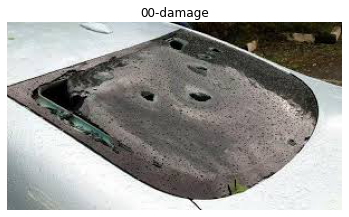

In [133]:
# View random image from training dataset
img = view_random_image(target_dir="car_damages/training/", target_class="00-damage")

['0191.JPEG']
Image shape: (137, 367, 3)
['0101.jpg']
Image shape: (380, 587, 3)


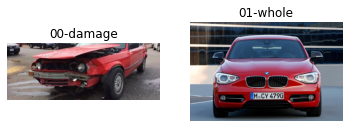

In [20]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("car_damages/training/", "00-damage")
plt.subplot(1,2,2)
pizza_img = view_random_image("car_damages/training/", "01-whole")

Notice how our images are in the form of arrays

X, Y, RGB

In [5]:
# The images we've imported and plotted are actually giant array/tensors of different pixel values
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(194, 259, 3), dtype=uint8, numpy=
array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[137, 131, 131],
        [141, 135, 135],
        [145, 139, 139],
        ...,
        [105, 105, 103],
        [105, 105, 103],
        [104, 104, 102]],

       [[136, 135, 133],
        [159, 158, 156],
        [129, 128, 126],
        ...,
        [104, 105, 107],
        [101, 102, 104],
        [ 98,  99, 101]],

       [[150, 149, 147],
        [145, 144, 142],
        [115, 114, 112],
        ...,
        [104, 105, 10

In [6]:
# View the image shape
img.shape # returns, width, height, colour channels

(194, 259, 3)

🔑 **Note:** many machine learning models including neural networks prefer the values they with with to be between 0 and 1. knowing this, one of the most common preprocessing steps for working with images is to scale (also reffered to as normalize) their pixel values by dividing the image arrays by 255 (since 255 is the maximum pixel value).

In [7]:
#ie. normalize the images/data, we are going to be doing this in a bigger scale using ImageDataGenerator
img/255.

array([[[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       ...,

       [[0.5372549 , 0.51372549, 0.51372549],
        [0.55294118, 0.52941176, 0.52941176],
        [0.56862745, 0

## Create Training and Validation data set

We will pass our directors to the ImageDataGenerator to handle our classification

In [152]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixels values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup Paths to data directory
train_dir = "/content/car_damages/training"
test_dir = "/content/car_damages/validation"


#Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir, 
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)


Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Create the model

In [9]:
# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224,224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),

    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


## Compile the model

In [10]:
# Compile our CNN
model_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


## Fit the model

In [11]:
# Fit the model
history = model_1.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data))

Epoch 1/5
58/58 [==============================] - 27s 182ms/step - loss: 0.6601 - accuracy: 0.5995 - val_loss: 0.6249 - val_accuracy: 0.6413
Epoch 2/5
58/58 [==============================] - 10s 173ms/step - loss: 0.5491 - accuracy: 0.7364 - val_loss: 0.5713 - val_accuracy: 0.7217
Epoch 3/5
58/58 [==============================] - 10s 173ms/step - loss: 0.4852 - accuracy: 0.7793 - val_loss: 0.4924 - val_accuracy: 0.7500
Epoch 4/5
58/58 [==============================] - 10s 175ms/step - loss: 0.4089 - accuracy: 0.8163 - val_loss: 0.4965 - val_accuracy: 0.7543
Epoch 5/5
58/58 [==============================] - 10s 173ms/step - loss: 0.3520 - accuracy: 0.8516 - val_loss: 0.5251 - val_accuracy: 0.7500


## View model summary

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

# Lets create a model without convolutional networks

In [13]:
#Set random seed
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224,224,3)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_2 = model_2.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/5
58/58 [==============================] - 11s 175ms/step - loss: 1.4678 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
58/58 [==============================] - 10s 172ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
58/58 [==============================] - 10s 170ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
58/58 [==============================] - 10s 170ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
58/58 [==============================] - 10s 170ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [14]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


As you can see with model 2 we can the model is basically guessing, its not doing a great job at finding pattens

## Add More Layers 
(testing w/o conv2d and maxpooling layers)

In [15]:
#Set random seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([                    
  tf.keras.layers.Flatten(input_shape=(224,224,3)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_3 = model_3.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/5
58/58 [==============================] - 11s 177ms/step - loss: 5.6244 - accuracy: 0.5054 - val_loss: 0.7437 - val_accuracy: 0.5783
Epoch 2/5
58/58 [==============================] - 10s 169ms/step - loss: 0.8099 - accuracy: 0.5761 - val_loss: 0.6367 - val_accuracy: 0.6391
Epoch 3/5
58/58 [==============================] - 10s 171ms/step - loss: 0.6401 - accuracy: 0.6467 - val_loss: 0.7051 - val_accuracy: 0.5609
Epoch 4/5
58/58 [==============================] - 10s 172ms/step - loss: 0.6308 - accuracy: 0.6511 - val_loss: 0.8062 - val_accuracy: 0.5457
Epoch 5/5
58/58 [==============================] - 10s 170ms/step - loss: 0.6327 - accuracy: 0.6408 - val_loss: 0.6653 - val_accuracy: 0.5978


In [16]:
# Get a summaey od model_3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Look at how many params we have compared to our first model. 

CNN are extremely powerful at finding features within an images. to get a better understanding of CNN

https://poloclub.github.io/cnn-explainer/

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

# Improving our model
* We can improve our model with data augmentation
* Data augmentation allows you to transform your images to better find patterns (In this example we will use data augmentation to normalize and horizontal flip some images in our taining data set (We do not augment test data)

In [21]:
# Create train and test data generators and rescale the data

# Define directory dataset paths
train_dir = "car_damages/training/"
test_dir = "car_damages/validation/"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255., # zoom in randomly on an image
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [22]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               batch_size=32,
                                               shuffle=True)
test_data = train_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               batch_size=32)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


### Create, compile, summary, fit

In [23]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Conv2D, Activation
from tensorflow.keras import Sequential

In [24]:
# Create the model
model_4 = Sequential([
  Conv2D(filters=10, # filter is the number of sliding windows going across an input (higher = more complex model)
         kernel_size=3,  # the size of the sliding window going across an input
         strides=1, # the size of the step the sliding windows takes  across an input
         padding='valid',  #if same output shape is same as input shape, if valid 
         activation='relu', 
         input_shape=(224,224,3)), #input layer (specify input shape)
  Conv2D(10, 3, activation="relu"), 
  Conv2D(10, 3, activation="relu"),
  Flatten(),
  Dense(1, activation="sigmoid") # output layer (working with binary classification so only 1 output neuron)
])

In [25]:
# Compile the model
model_4.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [26]:
# Get a summary of our model
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Fit the model
history_4 = model_4.fit(train_data, #this is a combinations of labels and data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
58/58 [==============================] - 11s 184ms/step - loss: 1.0443 - accuracy: 0.5755 - val_loss: 0.5916 - val_accuracy: 0.6913
Epoch 2/5
58/58 [==============================] - 10s 180ms/step - loss: 0.5593 - accuracy: 0.7283 - val_loss: 0.4925 - val_accuracy: 0.7674
Epoch 3/5
58/58 [==============================] - 11s 182ms/step - loss: 0.4327 - accuracy: 0.8082 - val_loss: 0.4819 - val_accuracy: 0.7630
Epoch 4/5
58/58 [==============================] - 10s 182ms/step - loss: 0.2988 - accuracy: 0.8804 - val_loss: 0.4874 - val_accuracy: 0.7826
Epoch 5/5
58/58 [==============================] - 10s 179ms/step - loss: 0.2050 - accuracy: 0.9293 - val_loss: 0.5727 - val_accuracy: 0.7761


### View metrics of our models
Our model data is doing much better, with a high accuracy and lower loss, we are increasing our models prediction performance

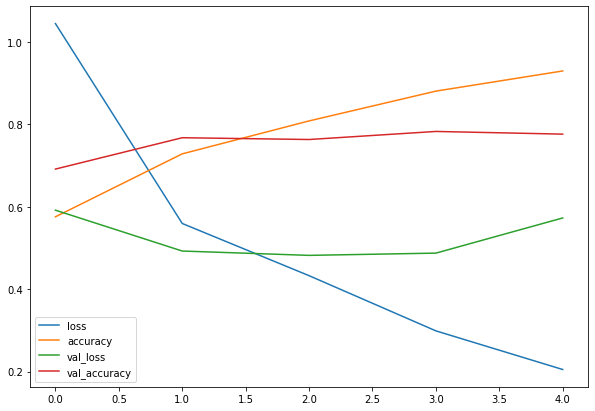

In [28]:
# Lets plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10,7))
import matplotlib.pyplot as plt

In [29]:
#Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  
  epochs = range(len(history.history["loss"])) # how many epochs did we run for

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

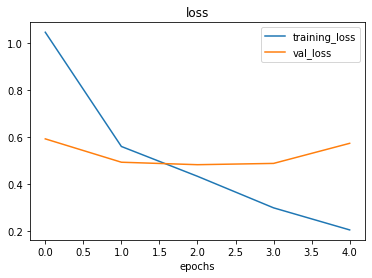

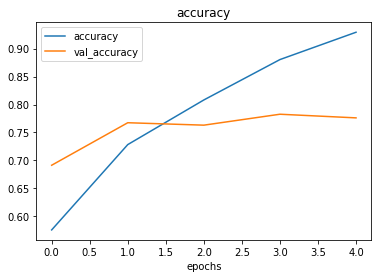

In [30]:
# Check out the loss and accuracy of model 4
plot_loss_curves(history_4)

Model 4 performed decently well (It's important that the training loss and accuracy are close together

## Test a new model
Lets keep testing and see what we can do to improve our model

In [31]:
# Create the model (this is going our new baseline)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation="sigmoid")
])

### Lets change our optimizer parameters

In [32]:
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-7, amsgrad=False),
                metrics=["accuracy"])

In [33]:
history_5 = model_5.fit(train_data, epochs=15, 
            validation_data=test_data, 
            steps_per_epoch=len(train_data),
            validation_steps=len(valid_data))

Epoch 1/15
58/58 [==============================] - 11s 184ms/step - loss: 0.7001 - accuracy: 0.5277 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 2/15
58/58 [==============================] - 10s 177ms/step - loss: 0.6518 - accuracy: 0.6266 - val_loss: 0.6227 - val_accuracy: 0.6630
Epoch 3/15
58/58 [==============================] - 10s 176ms/step - loss: 0.5996 - accuracy: 0.6815 - val_loss: 0.5893 - val_accuracy: 0.6761
Epoch 4/15
58/58 [==============================] - 10s 180ms/step - loss: 0.5739 - accuracy: 0.6935 - val_loss: 0.5814 - val_accuracy: 0.6826
Epoch 5/15
58/58 [==============================] - 10s 178ms/step - loss: 0.5516 - accuracy: 0.7152 - val_loss: 0.5473 - val_accuracy: 0.7217
Epoch 6/15
58/58 [==============================] - 10s 177ms/step - loss: 0.5194 - accuracy: 0.7391 - val_loss: 0.5262 - val_accuracy: 0.7239
Epoch 7/15
58/58 [==============================] - 10s 178ms/step - loss: 0.5016 - accuracy: 0.7511 - val_loss: 0.5176 - val_accuracy: 0.7370

In [34]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

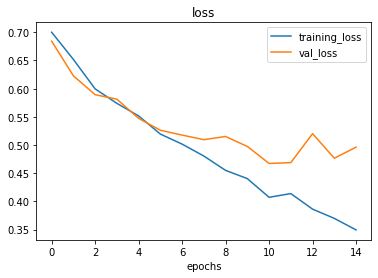

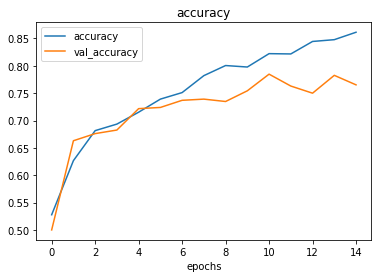

In [35]:
plot_loss_curves(history_5)

That looks a bit more accurate than our model 4 metrics which is good

In [36]:
# View our example image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

!rm damage_car.jpg
!rm whole_car.jpg
!wget https://dss.fosterwebmarketing.com/upload/dhclaw.com/39504259%20totaled%20car.jpg
!wget https://imgd.aeplcdn.com/0x0/n/cw/ec/27074/civic-exterior-right-front-three-quarter-148156.jpeg
!mv "39504259 totaled car.jpg" "damage_car.jpg"
!mv "civic-exterior-right-front-three-quarter-148156.jpeg" "whole_car.jpeg"


rm: cannot remove 'damage_car.jpg': No such file or directory
rm: cannot remove 'whole_car.jpg': No such file or directory
--2021-06-29 14:37:10--  https://dss.fosterwebmarketing.com/upload/dhclaw.com/39504259%20totaled%20car.jpg
Resolving dss.fosterwebmarketing.com (dss.fosterwebmarketing.com)... 8.25.5.137
Connecting to dss.fosterwebmarketing.com (dss.fosterwebmarketing.com)|8.25.5.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75640 (74K) [image/jpeg]
Saving to: ‘39504259 totaled car.jpg’

39504259 totaled ca 100%[===================>]  73.87K  --.-KB/s    in 0.09s   

2021-06-29 14:37:11 (829 KB/s) - ‘39504259 totaled car.jpg’ saved [75640/75640]

--2021-06-29 14:37:11--  https://imgd.aeplcdn.com/0x0/n/cw/ec/27074/civic-exterior-right-front-three-quarter-148156.jpeg
Resolving imgd.aeplcdn.com (imgd.aeplcdn.com)... 92.122.94.64, 23.202.229.65
Connecting to imgd.aeplcdn.com (imgd.aeplcdn.com)|92.122.94.64|:443... connected.
HTTP request sent, awaiting r

'00-damage'

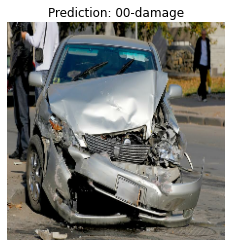

In [37]:
pred_and_plot(model_4, 'damage_car.jpg', class_names)

'00-damage'

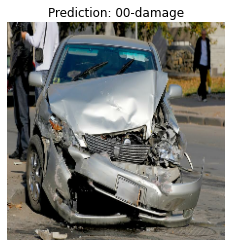

In [38]:
pred_and_plot(model_5, 'damage_car.jpg', class_names)

'01-whole'

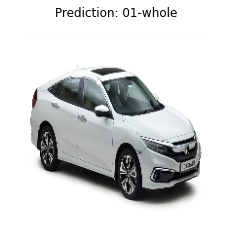

In [41]:
pred_and_plot(model_4, 'whole_car.jpeg', class_names)

1


'01-whole'

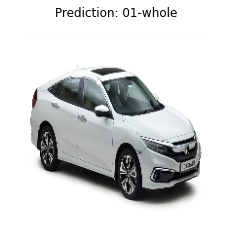

In [134]:
pred_and_plot(model_5, 'whole_car.jpeg', class_names)

# Power of Transfer Learning

In [42]:
# LEts compare the following two model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

import tensorflow_hub as hub
from tensorflow.keras import layers

In [57]:
IMAGE_SHAPE = (224, 224)
# Let's make a create model function to create a model from a URL
def create_model(model_url, num_classes=1, name="feature_extraction_layer"):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, 
                                           name=name,
                                           input_shape=IMAGE_SHAPE+(3,)) # feeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation="sigmoid", name="output_layer")
  ])

  return model


## Resnet50V2

In [58]:
tf.random.set_seed(42)
resnet_model = create_model(resnet_url,  num_classes=1)

In [59]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [60]:
# Compile our resnet model
resnet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=["accuracy"])

In [61]:
history_resnet = resnet_model.fit(train_data, 
                 epochs=5, 
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data))

Epoch 1/5
58/58 [==============================] - 15s 197ms/step - loss: 0.4461 - accuracy: 0.7908 - val_loss: 0.2870 - val_accuracy: 0.8804
Epoch 2/5
58/58 [==============================] - 11s 190ms/step - loss: 0.2859 - accuracy: 0.8842 - val_loss: 0.2514 - val_accuracy: 0.8957
Epoch 3/5
58/58 [==============================] - 11s 190ms/step - loss: 0.2421 - accuracy: 0.9065 - val_loss: 0.2262 - val_accuracy: 0.9174
Epoch 4/5
58/58 [==============================] - 11s 190ms/step - loss: 0.2175 - accuracy: 0.9168 - val_loss: 0.2259 - val_accuracy: 0.9196
Epoch 5/5
58/58 [==============================] - 11s 190ms/step - loss: 0.1995 - accuracy: 0.9283 - val_loss: 0.2208 - val_accuracy: 0.9261


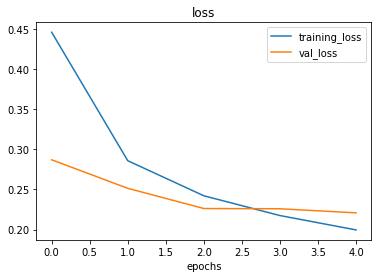

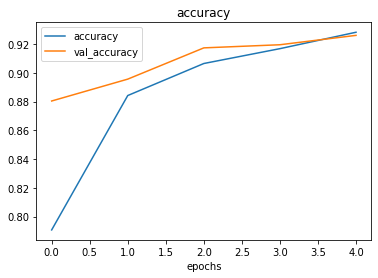

In [62]:
plot_loss_curves(history_resnet)

## EfficientNet_B0

In [63]:
tf.random.set_seed(42)
b0_model = create_model(efficientnet_url,  num_classes=1)

In [64]:
b0_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [65]:
# Compile our b0 model
b0_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=["accuracy"])

In [66]:
history_b0 = b0_model.fit(train_data, 
                 epochs=5, 
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data))

Epoch 1/5
58/58 [==============================] - 19s 205ms/step - loss: 0.4562 - accuracy: 0.8158 - val_loss: 0.3172 - val_accuracy: 0.8761
Epoch 2/5
58/58 [==============================] - 11s 182ms/step - loss: 0.3091 - accuracy: 0.8891 - val_loss: 0.2605 - val_accuracy: 0.9065
Epoch 3/5
58/58 [==============================] - 11s 183ms/step - loss: 0.2635 - accuracy: 0.9103 - val_loss: 0.2322 - val_accuracy: 0.9152
Epoch 4/5
58/58 [==============================] - 11s 184ms/step - loss: 0.2354 - accuracy: 0.9163 - val_loss: 0.2142 - val_accuracy: 0.9130
Epoch 5/5
58/58 [==============================] - 11s 184ms/step - loss: 0.2192 - accuracy: 0.9234 - val_loss: 0.2044 - val_accuracy: 0.9109


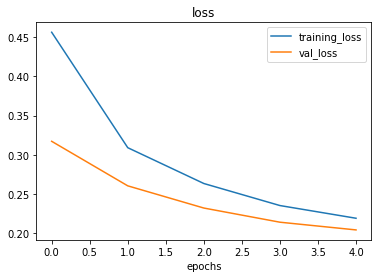

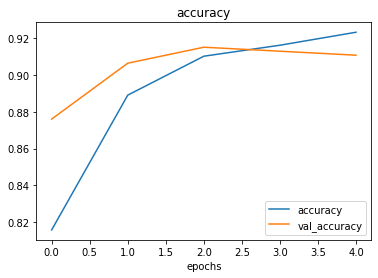

In [67]:
plot_loss_curves(history_b0)

## Resolution

With the power of transfer learning we can build a more accurate model than ever. Of course we could tweak our model without TL but i think our model is doing pretty well.

b0 looks promising. With fewer neural networks parameters it did pretty well with 5 times as less params

# Save Our Model

In [113]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb


"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Car Damage binary classifier"
model_meta.description = ("Determine if a car is damaged or whole using EfficientNet B0")
model_meta.version = "v1"
model_meta.author = "Charlton Smith"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [ ]:
b0_model.save("b0_model.h5")
!mkdir tflite
converter = tf.lite.TFLiteConverter.from_keras_model(b0_model)
tflite_model = converter.convert()
open("tflite/b0_model.tflite", "wb").write(tflite_model)

In [138]:
string = """
item {
  name: "00-damage"
  id: 0
}
item {
  name: "01-whole"
  id: 1
}
"""
open("tflite/labelmap.txt", "w").write(string)

74

In [139]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [140]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [141]:
labelmap_file = "/content/tflite/labelmap.txt"
export_model_path = "/content/tflite/b0_model.tflite"

In [142]:
import os

In [143]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 1001 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(labelmap_file)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [144]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [146]:
populator = _metadata.MetadataPopulator.with_model_file(export_model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["/content/tflite/labelmap.txt"])
populator.populate()

In [147]:
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join("/content/tflite", #"detect.json")
                    os.path.splitext(os.path.basename(export_model_path))[0] + ".json")
json_file = displayer.get_metadata_json()
# Optional: write out the metadata as a json file
with open(export_json_file, "w") as f:
  f.write(json_file)